# How to use this notebook

**Section 1. Data import and cleaning**. This section marshals and cleans the source ICLab dataset. It produces `iclabCLEAN.pkl`.

**Section 2. Experiments**. This walks through the various experiments we undertook to produce our metric. It starts by loading `iclabCLEAN.pkl` and finishes by producing `MetricDF.pkl`.

**Section 3. Hypothesis testing**. This walks through the various experiments we undertook to produce our metric. It starts by loading `MetricDF.pkl` and does not produce any output to disk.


In [1]:
!pip install tldextract
!pip install pycountry
!pip install jupyterthemes

You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import os
import re
import tldextract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import os, time, http.client
from termcolor import colored
import sys
import json
from pygments import highlight, lexers, formatters
import pycountry
import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import statistics

# Tools for visualizing the data

# requires jupytertehmes

%pylab inline
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

Populating the interactive namespace from numpy and matplotlib


# Section 1. Data import and cleaning

This section imports and cleans  all the [ICLab data](https://iclab.org/post/iclab_data/) as of this writing, 2020-07-22. 

If you want to add new data, or clean our data differently, edit this section.

**If you are interested in metric computation or hypothesis testing, SKIP THIS SECTION. You can load the cleaned data at the beginning of Sections 2 and 3**.

If you would like to continue, you'll need to [download combined.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48). This is a large (8GB) file.
It is created by concatenating all of the ICLab data (see link above).

In [3]:
# make sure you've downloaded combined.csv - see link above.
# WARNING - this is a large dataset and will produce some memory pressure.
iclabcombined = pd.read_csv("../data/combined.csv", dtype={'country' : str})

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,10,11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Drop the columns which were meant for internal use of ICLAB team and the header columns which have come into dataset via join.

In [4]:
iclabcombined.drop(['filename', 'as_number'], axis=1, inplace= True)

iclabcombined.drop([ 3078134,  4235577, 12411076, 18967078, 25041685, 26600938,
            28192530, 29460039, 30795516, 32569776, 34391850, 36093972,
            37793956, 39298313, 40934970, 42276914, 42976448, 44455181,
            47068048, 49383978], inplace = True)

Correcting wrongly coded boolean values in the datasets

In [5]:
iclabcombined['dns'].replace('false',False,inplace=True)
iclabcombined['dns_all'].replace('false',False,inplace=True)
iclabcombined['block'].replace('false',False,inplace=True)
iclabcombined['packet_updated'].replace('false',False,inplace=True)
iclabcombined['censored_updated'].replace('false',False,inplace=True)

iclabcombined['dns'].replace('true',True,inplace=True)
iclabcombined['dns_all'].replace('true',True,inplace=True)
iclabcombined['block'].replace('true',True,inplace=True)
iclabcombined['packet_updated'].replace('true',True,inplace=True)
iclabcombined['censored_updated'].replace('true',True,inplace=True)

## 1a. Merging with Fortiguard categories

We'll also be importing the Fortiguard categories for each URL blocked, and merging them into our dataset of blocking observations.

The result will be a list of ICLab blocking observations, along with the Fortiguard category for each URL observed.

In [6]:
catDF = pd.read_fwf('../data/type_domain_mapping.txt',header=None, names=[ "Name"], sep="")

In [7]:
catDF = catDF.Name.apply(lambda x: pd.Series(str(x).split("|||"))).rename(columns={0:'category',1:'site'})

In [8]:
allCategories = set(catDF['category'])
len(allCategories)

80

In [9]:
# ADDING CATEGORY AS A PERMANENT COLUMN
urlListAll = iclabcombined['url'].tolist()
sitesListAll = []
for item in urlListAll:
    domainAll = tldextract.extract(item)[1]
    suffixAll = tldextract.extract(item)[2]
    sitesListAll.append(domainAll + "." + suffixAll)

In [10]:
iclabcombined['site'] = sitesListAll
iclabcombined = pd.merge(iclabcombined, catDF, on='site',how='left')

In [11]:
iclabcombined['category'] = iclabcombined['category'].fillna(0)
iclabcombined['category']=iclabcombined['category'].replace(0,'Undefined')
iclabcombined.head()

,server_t,country,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site,category
0,2017-01-01T00:03:55.797Z,UA,alexa-global,4shared.com,False,sameip,False,NaN,200,False,89694,NaN,NaN,NaN,False,4shared.com,File Sharing and Storage
1,2017-01-01T00:03:55.797Z,UA,alexa-global,quora.com,-2,no_control_resp,False,NaN,200,False,99907,NaN,NaN,NaN,False,quora.com,Reference
2,2017-01-01T00:03:55.797Z,UA,alexa-global,stackexchange.com,-2,no_control_resp,False,NaN,200,False,83096,NaN,NaN,NaN,False,stackexchange.com,Information Technology
3,2017-01-01T00:03:55.797Z,UA,alexa-global,whatsapp.com,-2,no_control_resp,False,NaN,200,False,32799,NaN,NaN,NaN,False,whatsapp.com,Instant Messaging
4,2017-01-01T00:03:55.797Z,UA,alexa-global,atlassian.net,-2,no_control_resp,False,NaN,200,False,38180,NaN,NaN,NaN,False,atlassian.net,Information Technology


Now we're going to save this to CSV. This allows us to save time and memory.

In [12]:
iclabcombined.to_csv('../data/iclab_cleaned_data/iclab-full-fortiguard.csv')

## 1b. Adding missing Fortiguard categories
I recommend restarting your Jupyter kernel now. That will clear your memory out. Then you can load this file again and do the remaining data cleaning steps.

**You could beenfit from access to our Fortiguard database to replicate this step.** Please contact the research team if you would like to request access.

However, access is not absolutely required. See `config.example.py` for an example on how to point to your Postgres instance. Then use `create-tables.py` to set up your Postgres database to take this format. You can use this code to create your own cache of Fortiguard categories without access to our database.

In [36]:
iclabcombined = pd.read_csv('../data/iclab_cleaned_data/iclab-full-fortiguard.csv').drop(columns=["Unnamed: 0"])

KeyboardInterrupt: 

In [40]:
print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))

The number of observations in our original data set are 50436846 and the number of features/columns are 17 


In [31]:
logging.basicConfig()
logger = logging.getLogger("poll-ooni")

In [72]:
import requests 
from time import sleep
from bs4 import BeautifulSoup
from typing import Optional

from config import config

# # Find Fortiguard categories
#
# We now want to get the Fortiguard categories for all the URLs. This tells us
# (very roughly) what the websites are "about."

def query_fortiguard_category (url) -> str:
    html_doc = requests.get('https://fortiguard.com/webfilter?q={!s}'.format(url)).text
    soup = BeautifulSoup(html_doc, 'html.parser')
    return soup.h4.get_text().split(': ')[1]

def lookup_category (cursor, url) -> str:
    cursor.execute("SELECT fortiguard_category FROM fortiguard_categories WHERE url='{!s}'".format(url))
    return cursor.fetchone()[0]

def get_fortiguard_category (cursor, url) -> Optional[str]:
    '''Get the Fortiguard category for a given URL. We'll check our database
    first. If we can't find the category there, we will scrape Fortiguard's
    webpage to get the category. '''
    # try to retrieve the category from the database
    try:
        category = lookup_category(cursor, url)
        logger.debug("Retrieved {!s} ({!s}) from database".format(url, category))
        return category
    # if we can't find it,
    except TypeError:
        logger.info("Querying {!s} from Fortiguard".format(url))
    try:
        # sleep so as to not overwhelm the endpoint
        sleep(config['sleep-times']['fortiguard'])
        # now query it
        category = query_fortiguard_category(url)
        # add url/cateogry mapping to database
        logger.debug("Adding {!s} ({!s}) to database".format(url, category))
        insert_fortiguard_category(cur, url, category)
        conn.commit()
        # return the category
        return category
    # if there's some other error,
    except:
        logger.debug("Some error looking up {!s} from Fortiguard".format(url))
        # return None
        return None

## Database stuff

def insert_fortiguard_category (cursor, url, category):
    cursor.execute("""
    INSERT INTO fortiguard_categories
    (url, fortiguard_category)
    VALUES
    (%s, %s)
    """, (
        url,
        category,
    ))


In [47]:
import psycopg2

conn = psycopg2.connect(**config['postgres'])
logger.info("Made connection to the database:",  conn.get_dsn_parameters())
cur = conn.cursor()
logger.debug("Made database cursor.")

In [73]:
undefined_sites = iclabcombined['category']=='Undefined'

In [74]:
for i, is_undefined in undefined_sites.iteritems():
    if is_undefined:
        record = iclabcombined.iloc[i]
        site = record['site']
        # check db to see if we've dl'd category
        # if not, scrape fortiguard for website & add category to db
        category = get_fortiguard_category(cur, site)
        # if we found a category, update it in iclabcombined
        if category:
            iclabcombined.loc[i, 'category'] = category
        else:
            print(i, 'Some issue scraping category for', site)

KeyboardInterrupt: 

In [ ]:
conn.close()
cur.close()

iclabCLEAN is our cleaned dataframe

# Produce iclabCLEAN.csv

In [ ]:
iclabcombined.to_csv('../data/iclab_cleaned_data/iclabCLEAN.csv')

# Section 2.  Running experiments

In this section, we walk through the metrics with which we experimented in our paper.

At the end of this section, we produce `data/MetricDF.csv`, which contains all of our final metrics and associated data.

If you have NOT run Section 1, above, you'll need to [download iclabCLEAN.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

In [4]:
# WARNING - this is a pretty big file, and will prdouce some memory pessure
# iclabCLEAN = pd.read_pickle('../data/iclab_cleaned_data/iclabCLEAN.pkl')
iclabCLEAN = pd.read_csv('../data/iclab_cleaned_data/iclabCLEAN.csv').drop(columns=["Unnamed: 0"])

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Experiment 1: Exact URL blocking

In [5]:
blockpageTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
len(blockpageTR)

121

In [6]:
blockpageRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
len(blockpageRU)

340

In [7]:
blockpageTR.intersection(blockpageRU)

{'17ok.com',
 '39.net',
 'hclips.com',
 'http://1905.com/',
 'http://advocacy.globalvoicesonline.org/',
 'http://anonymouse.org',
 'http://anonymouse.org/',
 'http://bittornado.com',
 'http://bittornado.com/',
 'http://globalvoicesonline.org/',
 'http://hclips.com/',
 'http://hdzog.com/',
 'http://kdnet.net/',
 'http://warc.jalb.de/',
 'http://www.cameolingerieonline.com',
 'http://www.heritage.org',
 'http://www.hrcr.org',
 'http://www.hrcr.org/',
 'http://www.lineriderfun.com',
 'http://www.oovoo.com/',
 'http://www.schwarzreport.org/',
 'http://xhamster.com/',
 'xhamster.com'}

## Experiment 2: Fuzzy blocking

Most captured categories in our dataset

In [8]:
blockIN = set(iclabCLEAN[(iclabCLEAN['country']=='IN') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockIN)

519

In [9]:
blockRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True)| (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True))]['site'])
len(blockRU)

224

In [10]:
blockTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['site'])
len(blockTR)

102

In [11]:
blockNL = set(iclabCLEAN[(iclabCLEAN['country']=='NL') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockNL)

158

In [12]:
blockIN.intersection(blockRU)

{'17ok.com',
 '1905.com',
 '39.net',
 '3dmgame.com',
 'adobe.com',
 'anonymouse.org',
 'arablounge.com',
 'baidu.com',
 'bittornado.com',
 'blogspot.com',
 'blogspot.in',
 'buddhanet.net',
 'cameolingerieonline.com',
 'dailymotion.com',
 'doublepimp.com',
 'ebay.it',
 'facebook.com',
 'fanpage.gr',
 'globalvoicesonline.org',
 'guildwars.com',
 'hdzog.com',
 'heritage.org',
 'hrcr.org',
 'jalb.de',
 'kavkazcenter.com',
 'kdnet.net',
 'khilafah.net',
 'lineriderfun.com',
 'oovoo.com',
 'pandora.com',
 'peoplesproxy.com',
 'rutracker.org',
 'sabah.com.tr',
 'sberbank.ru',
 'schwarzreport.org',
 'sectsco.org',
 'sozcu.com.tr',
 'tmall.com',
 'wordpress.com',
 'youtube.com'}

In [13]:
blockRU.intersection(blockTR)

{'17ok.com',
 '1905.com',
 '39.net',
 'anonymouse.org',
 'bittornado.com',
 'cameolingerieonline.com',
 'globalvoicesonline.org',
 'hclips.com',
 'hdzog.com',
 'heritage.org',
 'hrcr.org',
 'jalb.de',
 'kdnet.net',
 'lineriderfun.com',
 'oovoo.com',
 'schwarzreport.org',
 'wordpress.com',
 'xhamster.com'}

In [14]:
blockNL.intersection(blockTR)

{'17ok.com',
 '1905.com',
 '39.net',
 'anonymouse.org',
 'beeg.com',
 'bittornado.com',
 'cameolingerieonline.com',
 'chinadaily.com.cn',
 'e-hentai.org',
 'globalvoicesonline.org',
 'hclips.com',
 'heritage.org',
 'hrcr.org',
 'jalb.de',
 'kat.ph',
 'kdnet.net',
 'lineriderfun.com',
 'oovoo.com',
 'rarbg.to',
 'schwarzreport.org',
 'xhamster.com'}

As part of Experiment 2 : 
(a) A look at censored FB Pages in India

Looking at worldwide distribution of FB blocking

In [15]:
iclabCLEAN[iclabCLEAN['url'].str.contains('facebook')].groupby('country').count()

,server_t,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site,category
country,,,,,,,,,,,,,,,,
AD,6,6,6,6,5,6,2,6,6,6,0,0,0,6,6,6
AT,259,259,259,3,1,35,30,257,257,257,257,0,0,259,259,259
AU,1800,1800,1800,1243,881,1356,106,1742,1742,1742,1649,0,0,1800,1800,1800
BE,211,211,211,100,97,101,1,210,210,210,192,0,0,211,211,211
BG,550,550,550,522,213,525,0,529,529,529,487,0,0,550,550,550
BR,6740,6740,6740,5705,2382,6360,516,6677,6677,6677,6677,25,25,6740,6740,6740
BZ,293,293,293,45,43,45,0,293,293,293,265,0,0,293,293,293
CA,1008,1008,1008,155,49,364,196,1007,1007,1007,947,0,0,1008,1008,1008
CL,1867,1867,1867,1580,376,1635,0,1850,1850,1850,1811,24,24,1867,1867,1867


A look into religious censorship in the world

In [16]:
iclabCLEAN[ (iclabCLEAN['category'].isin(['Global Religion','Alternative Beliefs'])) & ( (iclabCLEAN['block']== True) | (iclabCLEAN['censored_updated'] == True) ) ].groupby(['country', 'site']).first()

server_t         schedule_name  \
country site                                                                    
CN      cefc.org               2018-06-29T12:46:51.538Z  country-sensitive-cn   
FR      khilafah.net           2017-03-30T04:29:38.024Z     citizenlab-global   
IN      ethiomuslimsmedia.com  2017-04-09T21:04:05.009Z  country-sensitive-in   
        hinduhumanrights.org   2017-03-09T09:45:35.370Z  country-sensitive-in   
        isaalmasih.net         2017-06-23T21:16:18.708Z     citizenlab-global   
        khilafah.com           2017-03-09T09:45:35.370Z     citizenlab-global   
        khilafah.net           2017-03-09T09:45:35.370Z     citizenlab-global   
KR      debate.org.uk          2017-01-10T00:10:37.747Z     citizenlab-global   
        emchurch.org           2017-01-10T00:10:37.747Z     citizenlab-global   
        iarf.net               2017-01-10T00:10:37.747Z     citizenlab-global   
        infidels.org           2017-01-10T00:10:37.747Z     citizenlab-global   
        islaminstitut.de       2017-01-13T00:19:19.932Z     citizenlab-global   
        islamonline.net        2017-01-03T00:17:24.763Z     citizenlab-global   
        jainworld.com          2017-01-18T00:15:46.119Z     citizenlab-global   
        torah.org              2017-01-03T00:17:24.763Z     citizenlab-global   
NL      christwire.org         2017-01-24T04:59:43.594Z     citizenlab-global   
        hizb-ut-tahrir.org     2017-07-18T03:27:09.971Z     citizenlab-global   
        khilafah.net           2017-12-31T13:37:30.925Z     citizenlab-global   
        wupj.org               2017-03-11T23:52:25.574Z     citizenlab-global   
PE      torah.org              2017-01-03T14:52:32.602Z     citizenlab-global   
RU      hizb-ut-tahrir.org     2017-01-05T09:08:01.678Z     citizenlab-global   
        khilafah.net           2017-01-05T09:08:01.678Z     citizenlab-global   
SA      khilafah.net           2017-03-05T08:59:40.652Z     citizenlab-global   
        krishna.com            2017-03-05T08:59:40.652Z     citizenlab-global   
TR      fgulen.com             2018-07-04T00:10:07.959Z  country-sensitive-tr   

                                                                             url  \
country site                                                                       
CN      cefc.org                                                http://cefc.org/   
FR      khilafah.net                                        http://khilafah.net/   
IN      ethiomuslimsmedia.com  http://ethiomuslimsmedia.com/index.php/news-pa...   
        hinduhumanrights.org     http://www.hinduhumanrights.org/hindufocus.html   
        isaalmasih.net                                    http://isaalmasih.net/   
        khilafah.com                                    http://www.khilafah.com/   
        khilafah.net                                        http://khilafah.net/   
KR      debate.org.uk                                       http://debate.org.uk   
        emchurch.org                                     http://www.emchurch.org   
        iarf.net                                             http://www.iarf.net   
        infidels.org                                     http://www.infidels.org   
        islaminstitut.de                                 http://islaminstitut.de   
        islamonline.net                               http://www.islamonline.net   
        jainworld.com                                   http://www.jainworld.com   
        torah.org                                           http://www.torah.org   
NL      christwire.org                                     http://christwire.org   
        hizb-ut-tahrir.org                        http://www.hizb-ut-tahrir.org/   
        khilafah.net                                        http://khilafah.net/   
        wupj.org                                                http://wupj.org/   
PE      torah.org                                           http://www.torah.org   
RU      hiz

## Experiment 3: Blocking by content category (our final metric)


### Exploring blocking by category

In [17]:
iclabCLEAN[iclabCLEAN['censored_updated']==True].groupby('category').count().sort_values(by='site',ascending=False).head(10)

,server_t,country,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site
category,,,,,,,,,,,,,,,,
Undefined,60172,60172,60172,60172,36650,23826,50414,14086,59961,59961,59961,53897,33150,33150,60172,60172
News and Media,22704,22704,22704,22704,10074,6221,18600,7670,22704,22704,22704,22610,18610,18610,22704,22704
Health and Wellness,19999,19999,19999,19999,8117,7196,12928,4650,19999,19999,19999,19173,19925,19925,19999,19999
Entertainment,19971,19971,19971,19971,7115,4340,15890,7787,19969,19969,19969,19962,15007,15007,19971,19971
Proxy Avoidance,16343,16343,16343,16343,7861,5511,12703,4458,16343,16343,16343,14834,15648,15648,16343,16343
Peer-to-peer File Sharing,15609,15609,15609,15609,7083,5447,11927,4459,15609,15609,15609,14141,15561,15561,15609,15609
Social Networking,11735,11735,11735,11735,2775,184,10837,7113,11734,11734,11734,11703,10428,10428,11735,11735
Pornography,10806,10806,10806,10806,9904,5657,10229,386,10806,10806,10806,10792,1478,1478,10806,10806
Games,10053,10053,10053,10053,3766,3087,6679,2654,10051,10051,10051,9963,10001,10001,10053,10053


In [18]:
def Category_contributions(cc):
    '''
    Computes contribution of each category in a countries blocked sites*
    '''
    catDataCC = iclabCLEAN[(iclabCLEAN['country']==cc) & (iclabCLEAN['censored_updated']==True) ]
    catDataCC= catDataCC.drop(['server_t', 'censored_updated','site','dns_all','packet_reason','url','dns','dns_reason','dns_reason_all','schedule_name','http_status','block','body_len','http_reason','packet_updated'], axis=1)
    catDataCC = catDataCC.groupby('category').count()
    catDataCC['%Cat'] = (catDataCC['country']*100)/(catDataCC['country'].sum())
    catDataCC= catDataCC.reset_index().drop('country',axis=1)
    catDataCC= catDataCC.rename(columns={'country':'Number of sites in' + str(cc),'%Cat':cc})
    return catDataCC

In [19]:
# Category_contributions('US')
Category_contributions('CA')

,category,CA
0,Brokerage and Trading,0.974930
1,Domain Parking,0.348189
2,Entertainment,10.828691
3,Games,8.983287
4,General Organizations,0.034819
5,Health and Wellness,19.603064
6,Illegal or Unethical,0.034819
7,Information Technology,0.069638
8,Meaningless Content,0.034819
9,News and Media,10.967967


In [20]:
INplot = Category_contributions('IN')
TRplot =Category_contributions('TR')
RUplot = Category_contributions('RU')
KRplot= Category_contributions('KR')
USplot = Category_contributions('US')
CNplot = Category_contributions('CN')
CAplot  = Category_contributions('CA')
ZAplot  = Category_contributions('ZA')

 Plotting the graph below:

In [21]:
graphcompare1 = pd.merge(INplot,TRplot, on='category', how='outer')
graphcompare2 = pd.merge(graphcompare1,KRplot, on='category', how='outer')
graphcompare3 = pd.merge(graphcompare2,RUplot, on='category', how='outer')
graphcompare4 = pd.merge(graphcompare3,USplot, on='category', how='outer')
graphcompare5 = pd.merge(graphcompare4,CNplot, on='category', how='outer')

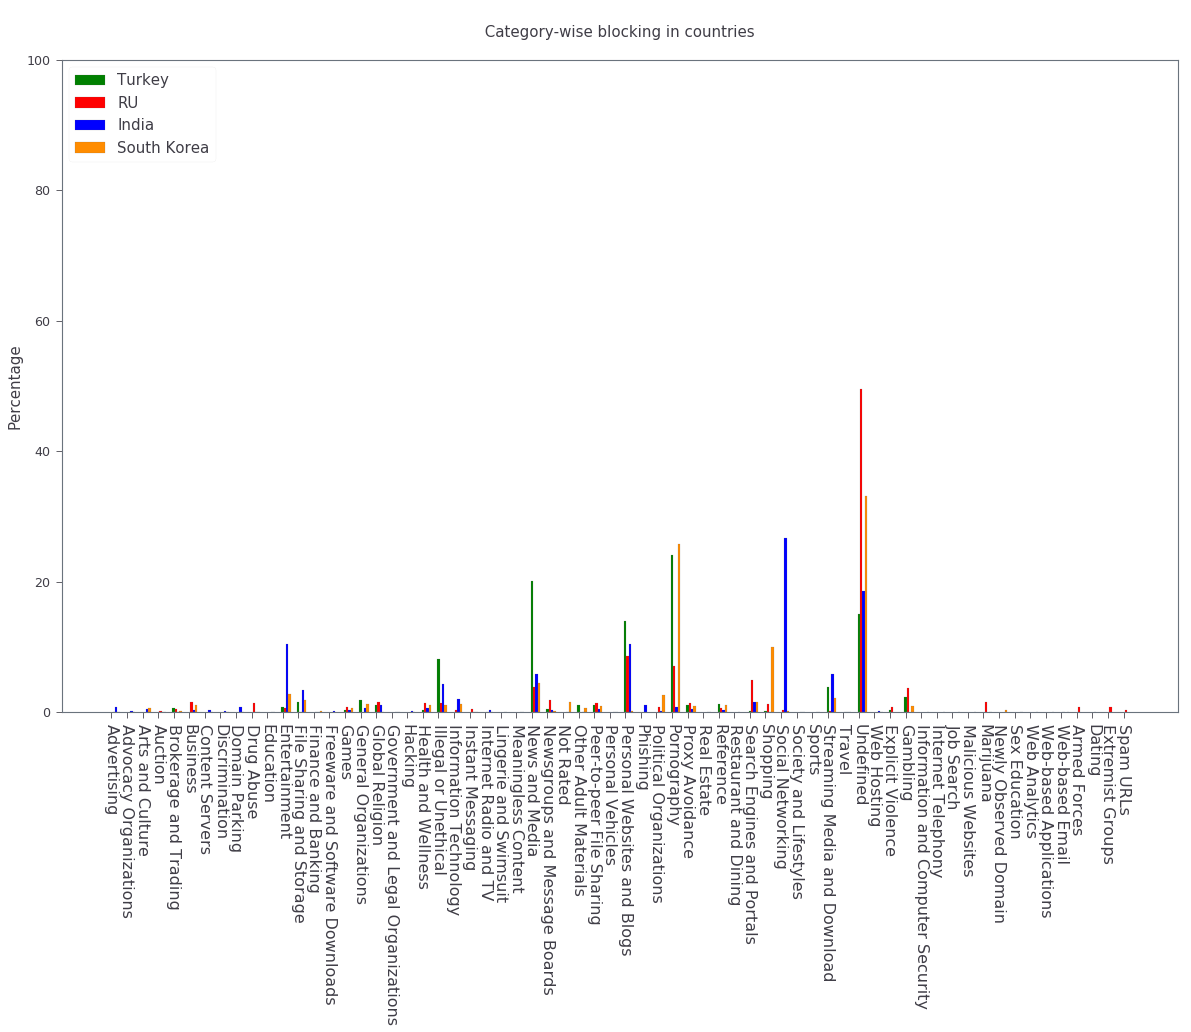

In [22]:
# set width of bar
barWidth = 0.15
 
# set height of bar
TR = graphcompare3['TR']
RU = graphcompare3['RU']
IN = graphcompare3['IN']
KR = graphcompare3['KR']
 
# Set position of bar on X axis
r1 = np.arange(len(TR))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.figure(figsize = (20,12))
plt.bar(r1, TR, color='green', width=barWidth, edgecolor='dimgrey', label='Turkey')
plt.bar(r2, RU, color='red', width=barWidth ,  edgecolor='dimgrey',label='RU')
plt.bar(r3, IN, color='blue', width=barWidth,  edgecolor='dimgrey',label='India')
plt.bar(r4, KR, color='darkorange', width=barWidth,  edgecolor= 'dimgrey',label='South Korea') 

# Add xticks on the middle of the group bars
plt.ylabel("Percentage", size=15)
plt.ylim(0,100)
plt.xticks([r for r in range(len(TR))], graphcompare3['category'].tolist() ,rotation=-90, size=16)

# Create legend & Show graphic
plt.legend(loc = 'upper left', fontsize = 15)
plt.title("\n Category-wise blocking in countries \n", size = 15)
plt.show()

### Producing a proxy from blocking by category

Here, we describe each country by the proportions of categories in which they block websites (e.g., 30% pornography, 70% gambling).

We then interpret these blocking cateogries as coordinates, and find the spatial cosine distance between any pair of two countries to produce a distance metric.

In [23]:
graphcompare5.fillna(0,inplace=True)

KRvals = graphcompare5['KR']
RUvals = graphcompare5['RU']
INvals = graphcompare5['IN']
TRvals = graphcompare5['TR']

In [24]:
KRsimilarityRU = (1 - spatial.distance.cosine(KRvals, RUvals))*100
print('india/russia', KRsimilarityRU)

INsimilarityTR = (1 - spatial.distance.cosine(INvals, TRvals))*100
print('india/turkey', INsimilarityTR)

INsimilarityKR = (1 - spatial.distance.cosine(INvals, KRvals))*100
print('india/korea', INsimilarityKR)

INsimilarityRU = (1 - spatial.distance.cosine(INvals, RUvals))*100
print('india/russia', INsimilarityRU)

KRsimilarityTR = (1 - spatial.distance.cosine(KRvals, TRvals))*100
print('korea/turkey', KRsimilarityTR)

RUsimilarityTR = (1 - spatial.distance.cosine(RUvals, TRvals))*100
print('russia/turkey', RUsimilarityTR)

india/russia 83.22426542796096
india/turkey 44.158715035832664
india/korea 44.90450469802651
india/russia 55.88219813515176
korea/turkey 73.25632615432515
russia/turkey 57.13891380413104


### Computing pairwise distance across all countries

We find the spatial cosine distance between **every** pair of two countries.

In [25]:
allCountries = (iclabCLEAN['country'].unique())
print("The total countries we have in our clean dataset are {}".format(len(allCountries)))

The total countries we have in our clean dataset are 55


In [26]:
allCategories = (iclabCLEAN['category'].unique())
print("The total unique categories we have in our clean dataset are {}".format(len(allCategories)))

The total unique categories we have in our clean dataset are 73


In [27]:
simMetricDF = pd.DataFrame(index = allCategories, columns=None)
simMetricDF['dummy']= pd.Series(np.zeros(len(simMetricDF)))
simMetricDF.reset_index(inplace=True)
simMetricDF.rename(columns={'index':'category'},inplace=True)
simMetricDF.head()

,category,dummy
0,File Sharing and Storage,NaN
1,Reference,NaN
2,Information Technology,NaN
3,Instant Messaging,NaN
4,News and Media,NaN


In [28]:
for country in allCountries:
    simMetricDF = pd.merge(simMetricDF,Category_contributions(country), on= 'category', how='outer')

In [29]:
simMetricDF.head()

,category,dummy,UA,CO,KR,US,BG,BZ,AU,JP,...,TR,PL,DZ,BR,SC,SA,AT,GR,CR,LI
0,File Sharing and Storage,NaN,NaN,NaN,1.854885,0.001238,NaN,NaN,0.123153,NaN,...,1.598677,NaN,NaN,NaN,NaN,0.339546,NaN,NaN,NaN,NaN
1,Reference,NaN,1.443124,1.430615,1.165492,1.374983,0.692841,0.917431,0.779967,1.554094,...,1.323043,1.353180,1.574803,1.887840,0.945946,NaN,0.972222,NaN,NaN,9.876543
2,Information Technology,NaN,2.037351,0.286123,1.268330,0.211631,0.230947,NaN,0.328407,0.537956,...,NaN,0.135318,NaN,0.166574,0.270270,1.069210,NaN,NaN,0.877193,NaN
3,Instant Messaging,NaN,NaN,NaN,0.041897,0.001238,NaN,NaN,NaN,0.059773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,News and Media,NaN,13.921902,13.590844,4.517235,12.600092,9.083911,4.587156,10.714286,11.775254,...,20.066152,11.231394,9.842520,13.214881,12.972973,3.677214,14.166667,11.111111,15.789474,19.753086


In [30]:
simMetricDF.set_index('category',inplace = True)

In [31]:
#REPLACING NaN's with 0
simMetricDF.fillna(0,inplace=True)

In [32]:
simMetricDF.drop("dummy",axis=1,inplace = True)

In [33]:
simMetricDF.head()

,UA,CO,KR,US,BG,BZ,AU,JP,NL,HK,...,TR,PL,DZ,BR,SC,SA,AT,GR,CR,LI
category,,,,,,,,,,,,,,,,,,,,,
File Sharing and Storage,0.000000,0.000000,1.854885,0.001238,0.000000,0.000000,0.123153,0.000000,0.000000,0.032680,...,1.598677,0.000000,0.000000,0.000000,0.000000,0.339546,0.000000,0.000000,0.000000,0.000000
Reference,1.443124,1.430615,1.165492,1.374983,0.692841,0.917431,0.779967,1.554094,2.189119,0.555556,...,1.323043,1.353180,1.574803,1.887840,0.945946,0.000000,0.972222,0.000000,0.000000,9.876543
Information Technology,2.037351,0.286123,1.268330,0.211631,0.230947,0.000000,0.328407,0.537956,0.233161,0.196078,...,0.000000,0.135318,0.000000,0.166574,0.270270,1.069210,0.000000,0.000000,0.877193,0.000000
Instant Messaging,0.000000,0.000000,0.041897,0.001238,0.000000,0.000000,0.000000,0.059773,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
News and Media,13.921902,13.590844,4.517235,12.600092,9.083911,4.587156,10.714286,11.775254,12.163212,35.163399,...,20.066152,11.231394,9.842520,13.214881,12.972973,3.677214,14.166667,11.111111,15.789474,19.753086


In [34]:
countryList =  allCountries.tolist()
numCatBlock = []

In [35]:
for item in countryList:
    numCatBlock.append(len(simMetricDF[simMetricDF[item]!=0]))

In [36]:
tempDF = pd.DataFrame(index=countryList)
tempDF['numCatBlock'] =numCatBlock
tempDF = tempDF.sort_values(by='numCatBlock',ascending = False)

In [37]:
#Getting all columns i.e. countries
simCols=[]
for i in range(len(simMetricDF.columns)):
    simCols.append(simMetricDF.columns[i])
print("We have {} unique countries".format(len(simCols)))

We have 55 unique countries


In [38]:
#Creating pairs to do calculation of spatial distance
from itertools import combinations
pairs = [comb for comb in sorted(combinations(simCols, 2))]
print("We have {} unique pairs from these countries including dummy".format(len(pairs)))

We have 1485 unique pairs from these countries including dummy


In [39]:
#Both vectors are non zeroes
print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['AU'], simMetricDF['IN']))))

# When even one vector is completeley a zero vector
print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['US'], simMetricDF['IN']))))

 **** Similarity is 0.4828392733242386 ****
 **** Similarity is 0.4783742057862431 ****


In [41]:
#NewSimVal will store the similarity value calculated from the spatial cosine distance formula

def dist (country1, country2):
    return 1 - (
        spatial.distance.cosine(
            simMetricDF[country1].values,
            simMetricDF[country2].values,
        )
    )
    

NewSimVals = []
for item in pairs:
    (country1, country2) = item
#     if (np.sum(simMetricDF[item[0]]) == 0) & (np.sum(simMetricDF[item[1]]) ==0):
#         NewSimVals.append((item,1))
#     elif (np.sum(simMetricDF[item[0]]) == 0) | (np.sum(simMetricDF[item[1]]) ==0):
#         NewSimVals.append((item,0))
#     else :
    NewSimVals.append((item, 
        dist(country1, country2)))

In [42]:
simMetricVals = pd.DataFrame(index=pairs, columns = None )
simMetricVals['similarity'] = [j for (i,j) in NewSimVals]
simMetricVals.reset_index(inplace=True)
simMetricVals.rename(columns={'index':'pair'},inplace=True)
simMetricVals[['country_code_alpha2_A', 'country_code_alpha2_B']] = pd.DataFrame(simMetricVals['pair'].tolist(), index=simMetricVals.index)
simMetricVals = simMetricVals[['pair','country_code_alpha2_A','country_code_alpha2_B','similarity']]
simMetricVals.head()

,pair,country_code_alpha2_A,country_code_alpha2_B,similarity
0,"(AD, AT)",AD,AT,0.688001
1,"(AD, BE)",AD,BE,0.747421
2,"(AD, BR)",AD,BR,0.752393
3,"(AD, CA)",AD,CA,0.733737
4,"(AD, CR)",AD,CR,0.598550


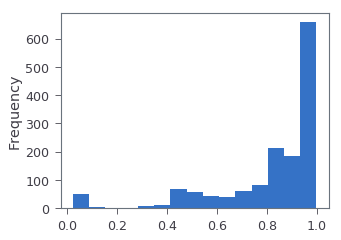

In [52]:
simMetricVals['similarity'].plot.hist(bins=15)

### Introducing blocking *volume* into metric.

While our first metric (above) gives us a good sense of blocking overlaps,
it fails to show us variation in the *volume* of blocking. Some countries have more blocking than others. We want to account for that.

We'll measure the volume of blocking in each country. We'll do that by measuring, for each country, the *proportion* of observations where `censored=True`.

In [53]:
NumSitesBlocked = iclabCLEAN.loc[
    (iclabCLEAN['censored_updated']==True),
    ['site','country']
].sort_values(by='country',ascending = False)

In [54]:
total_observations_by_country = iclabCLEAN.groupby('country').count()

In [55]:
total_blocked_observations_by_country = iclabCLEAN[iclabCLEAN['censored_updated']==True].groupby('country').count()

In [104]:
dummy_column_for_counting = 'server_t'

def as_single_column (df):
    return df[[dummy_column_for_counting]]

def proportion (row):
    blocked = row[dummy_column_for_counting+'_blocked']
    total = row[dummy_column_for_counting+'_total']
    return blocked / total


blocking_proporitons =\
as_single_column(total_blocked_observations_by_country)\
    .merge(as_single_column(total_observations_by_country),
           on='country', suffixes=('_blocked', '_total'))\
    .apply(proportion, axis=1)

blocking_proporitons

country
AD    0.002910
AT    0.003197
AU    0.003185
BE    0.003462
BG    0.002762
BR    0.001325
BZ    0.000444
CA    0.003412
CL    0.000914
CN    0.007894
CO    0.002568
CR    0.003318
CZ    0.003147
DK    0.003372
DZ    0.003422
ES    0.003197
FI    0.003202
FR    0.003372
GR    0.003521
HK    0.003529
HU    0.002680
ID    0.002492
IL    0.003268
IN    0.057488
IS    0.003019
JP    0.002852
KE    0.001833
KR    0.020348
LI    0.003260
LT    0.003261
LU    0.003413
MD    0.002620
MX    0.002213
MY    0.002776
NL    0.003184
NO    0.003448
NZ    0.003180
PE    0.002616
PL    0.003639
PT    0.003246
RO    0.001553
RS    0.002796
RU    0.014301
SA    0.105711
SC    0.002923
SE    0.003405
SG    0.003200
SK    0.003116
TR    0.024376
TW    0.000700
UA    0.002311
US    0.002981
VE    0.000826
VN    0.001500
ZA    0.003331
dtype: float64

Now we can compute the similarity in proportions between two countries.

In [105]:
def get_proportion (cc2):
    return blocking_proporitons[cc2]

def compute_similarity(proportion1, proportion2):
    # keep it simple....
    # minimum and maximum values will still be 0 and 1, since we're dealing with proportions.
    return 1 - abs(proportion1 - proportion2)

CountSimilarity = []
for item in pairs:
    (country1, country2) = item
    similarity = compute_similarity(get_proportion(country1), get_proportion(country2))
    if not similarity >0:
        print(country1, country2, similarity, get_proportion(country1), get_proportion(country2))
        raise 
    CountSimilarity.append((item, similarity))

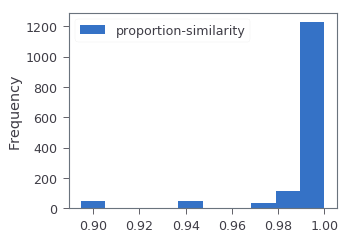

In [106]:
blocking_proportion_similarities =\
pd.DataFrame(CountSimilarity, columns=[
    'pair',
    'proportion-similarity'
])
blocking_proportion_similarities.plot.hist()

Not much variation here. That's okay. We'll just min-max normalize it.

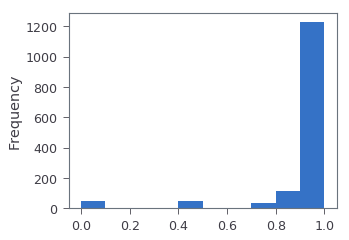

In [107]:
def min_max_norm(series):
    return (series-series.min())/(series.max()-series.min())

blocking_proportion_similarities['proportion-similarity-normalized'] = \
    min_max_norm(blocking_proportion_similarities['proportion-similarity'])
blocking_proportion_similarities['proportion-similarity-normalized'].plot.hist()

plt.show()

## 4c. Merging these two

In [119]:
MetricDF = pd.merge(
    simMetricVals,
    blocking_proportion_similarities,
    on='pair',
    how='outer')
MetricDF = MetricDF.rename(columns={
    'similarity':'Censored_Category_Similarity',
    'proportion-similarity-normalized':'Blocking_Proportion_Similarity',
})
MetricDF['Overall_Similarity'] = (MetricDF['Censored_Category_Similarity']+ MetricDF['Blocking_Proportion_Similarity'])/2
MetricDF = MetricDF.sort_values(by='Overall_Similarity',ascending=False)
MetricDF

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity
961,"(NO, DK)",NO,DK,0.999213,0.999923,0.999271,0.999242
308,"(CO, PE)",CO,PE,0.998878,0.999951,0.999538,0.999208
783,"(LT, NZ)",LT,NZ,0.999067,0.999919,0.999227,0.999147
926,"(NL, IL)",NL,IL,0.999055,0.999916,0.999199,0.999127
1185,"(SE, LU)",SE,LU,0.998222,0.999992,0.999924,0.999073
...,...,...,...,...,...,...,...
599,"(IN, VE)",IN,VE,0.066841,0.943338,0.461735,0.264288
487,"(HK, SA)",HK,SA,0.477792,0.897818,0.029306,0.253549
1157,"(SA, CR)",SA,CR,0.474148,0.897607,0.027305,0.250726
266,"(CN, SA)",CN,SA,0.291390,0.902183,0.070775,0.181082


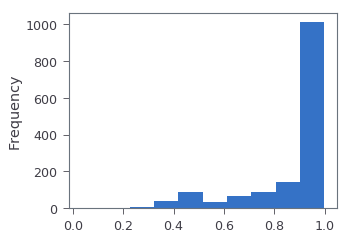

In [120]:
MetricDF['Overall_Similarity'].plot.hist()
plt.show()

In [121]:
# def countryCodeConversion()

iCA = MetricDF['country_code_alpha2_A']
iCB = MetricDF['country_code_alpha2_B']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


a3A = [countries.get(country, 'Unknown code') for country in iCA]
a3B = [countries.get(country, 'Unknown code') for country in iCB]

In [122]:
MetricDF['country_code_alpha3_A'] = a3A
MetricDF['country_code_alpha3_B'] = a3B

In [123]:
MetricDF.head()

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity,country_code_alpha3_A,country_code_alpha3_B
961,"(NO, DK)",NO,DK,0.999213,0.999923,0.999271,0.999242,NOR,DNK
308,"(CO, PE)",CO,PE,0.998878,0.999951,0.999538,0.999208,COL,PER
783,"(LT, NZ)",LT,NZ,0.999067,0.999919,0.999227,0.999147,LTU,NZL
926,"(NL, IL)",NL,IL,0.999055,0.999916,0.999199,0.999127,NLD,ISR
1185,"(SE, LU)",SE,LU,0.998222,0.999992,0.999924,0.999073,SWE,LUX


******************
#5 ***`GENERATING JSON`***
******************

*Dropping other columns for JSON conversion format compliance*

In [124]:
MetricDFJSON = MetricDF[['country_code_alpha3_A','country_code_alpha3_B','Overall_Similarity']]

In [125]:
MetricDFJSON.head()

,country_code_alpha3_A,country_code_alpha3_B,Overall_Similarity
961,NOR,DNK,0.999242
308,COL,PER,0.999208
783,LTU,NZL,0.999147
926,NLD,ISR,0.999127
1185,SWE,LUX,0.999073


In [126]:
pairs_of_similarities = {}
for _, row in MetricDFJSON.iterrows():
    country_pair = row.values[0] +'->'+ row.values[1]
    pairs_of_similarities[country_pair] = row.values[2]*100

In [129]:
output_json = json.dumps(pairs_of_similarities)

In [130]:
with open('data.json', 'w') as outfile:
    json.dump(output_json, outfile)

****************
# ***`6. Verifying results from 4 and 5`***

## 6a. Verifying results from 4 and 5

Why are there NA results for Greece and South Africa when data is present

In [ ]:
# iclabcombined[(iclabcombined['country']=='GR')&(iclabcombined['censored_updated']==True)]['site'].unique()

In [ ]:
# iclabcombined[(iclabcombined['country']=='ZA')&(iclabcombined['censored_updated']==True)]['site'].unique()

In [ ]:
# display(iclabcombined[(iclabcombined['country']=='GR')&(iclabcombined['censored_updated']==True)]['category'].unique())
# display(iclabcombined[(iclabcombined['country']=='ZA')&(iclabcombined['censored_updated']==True)]['category'].unique())

The NA results seem to be on account of dns being the column and values being zero for DNS in case of Greece

## 6b. Testing for different columns

In [ ]:
iclabcombined.isnull().sum(axis = 0)

server_t                   0
country                    0
schedule_name              0
url                        0
dns                 27829396
dns_reason          35216027
dns_all             13600017
dns_reason_all      37719857
http_status          2125476
block                2125476
body_len             2125476
http_reason          5185276
packet_updated      46636786
packet_reason       46636786
censored_updated           0
site                       0
category                   0
dtype: int64

In [ ]:
dummy_column_for_counting1 = 'block'

def as_single_column1 (df):
    return df[[dummy_column_for_counting1]]

def proportion1 (row):
    blocked = row[dummy_column_for_counting1+'_blocked']
    total = row[dummy_column_for_counting1+'_total']
    return blocked / total


blocking_proporitons1 =\
as_single_column1(total_blocked_observations_by_country)\
    .merge(as_single_column1(total_observations_by_country),
           on='country', suffixes=('_blocked', '_total'))\
    .apply(proportion1, axis=1)

In [ ]:
def get_proportion1 (cc2):
    # try to retrieve it
    try:
        return blocking_proporitons1[cc2]
    # if we don't have data on it
    except KeyError:
        # treat it as 0
        return 0

def compute_similarity1(proportion1, proportion2):
    # keep it simple....
    # minimum and maximum values will still be 0 and 1, since we're dealing with proportions.
    return 1 - abs(proportion1 - proportion2)

CountSimilarity1 = []
for item in pairs:
    (country1, country2) = item
    similarity1 = compute_similarity1(get_proportion1(country1), get_proportion1(country2))
    CountSimilarity1.append((item, similarity1))

In [ ]:
blocking_proportion_similarities1 =\
pd.DataFrame(CountSimilarity1, columns=[
    'pair',
    'proportion-similarity'
])
blocking_proportion_similarities1

,pair,proportion-similarity
0,"(AD, AT)",0.999677
1,"(AD, BE)",0.999441
2,"(AD, BR)",0.998499
3,"(AD, CA)",0.999493
4,"(AD, CR)",0.999595
...,...,...
1480,"(ZA, SG)",0.999847
1481,"(ZA, SK)",0.999613
1482,"(ZA, TR)",0.978443
1483,"(ZA, TW)",0.997163


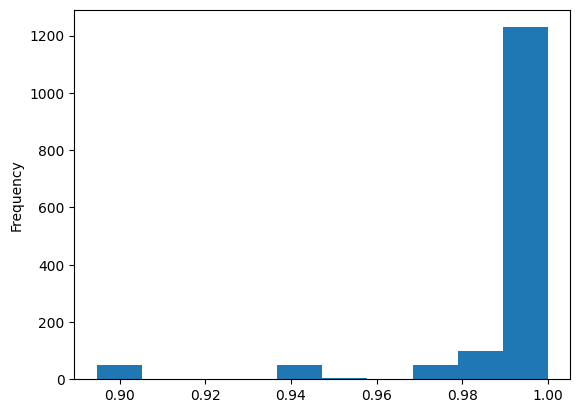

In [ ]:
blocking_proportion_similarities1['proportion-similarity'].plot.hist()
plt.show()

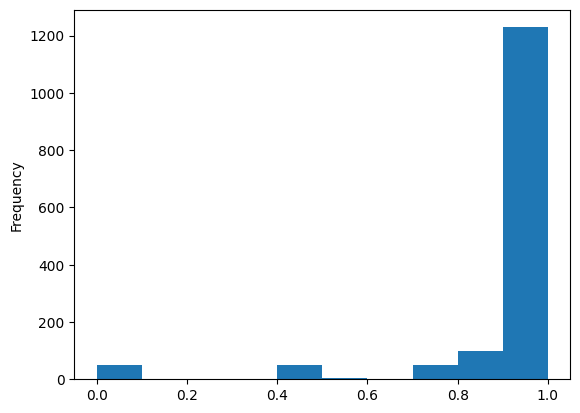

In [ ]:
def min_max_norm(series):
    return (series-series.min())/(series.max()-series.min())

blocking_proportion_similarities1['proportion-similarity-normalized'] = \
    min_max_norm(blocking_proportion_similarities1['proportion-similarity'])
blocking_proportion_similarities1['proportion-similarity-normalized'].plot.hist()

plt.show()

In [ ]:
MetricDF1 = pd.merge(simMetricVals,blocking_proportion_similarities1,on='pair',how='outer')
MetricDF1 = MetricDF1.rename(columns={
    'similarity':'Censored_Category_Similarity',
    'proportion-similarity-normalized':'Blocking_Proportion_Similarity',
})
MetricDF1['Overall_Similarity'] = (MetricDF1['Censored_Category_Similarity']+ MetricDF1['Blocking_Proportion_Similarity'])/2
MetricDF1 = MetricDF1.sort_values(by='Overall_Similarity',ascending=False)
MetricDF1

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity
961,"(NO, DK)",NO,DK,99.921272,0.999939,0.999424,50.460348
783,"(LT, NZ)",LT,NZ,99.906682,0.999900,0.999054,50.452868
926,"(NL, IL)",NL,IL,99.905538,0.999800,0.998099,50.451819
308,"(CO, PE)",CO,PE,99.887805,0.999957,0.999596,50.443700
377,"(ES, MD)",ES,MD,99.887884,0.999470,0.994966,50.441425
...,...,...,...,...,...,...,...
1227,"(SG, VE)",SG,VE,3.475451,0.997398,0.975288,2.225370
135,"(BG, VE)",BG,VE,3.224529,0.997901,0.980061,2.102295
1400,"(VE, CR)",VE,CR,2.410872,0.997508,0.976333,1.693602
271,"(CN, VE)",CN,VE,2.393743,0.992320,0.927041,1.660392


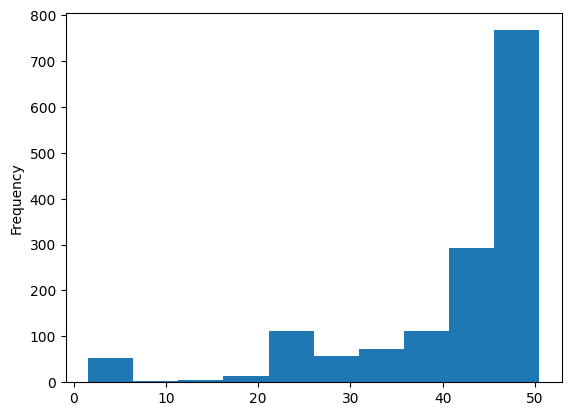

In [ ]:
MetricDF1['Overall_Similarity'].plot.hist()
plt.show()

****************
# 7. ***`HYPOTHESIS TESTING`***
****************

## Importing the Data

Importing the METRICDFJSON DataFrame

In [16]:
#MetricDFJSON.to_pickle("MetricDFJSON.pkl")
MetricDFJSON = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/MetricDFJSON.pkl")
MetricDFJSON = MetricDFJSON.dropna()
MetricDFJSON.shape

(1378, 3)

Importing non-Internet proxy data files

In [35]:
#Reading the NATO data
NATO = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/NATO.pkl")
NATO.shape

(29, 2)

In [22]:
#Prepping the WEF Data
WEF = pd.read_csv("../data/iclabcombined_and_hypothesis_data/WEFCompIndex.csv",index_col=0)
WEF['code'] = change_code(WEF['Country'])
missCodes =['TWN','KOR','IRL','CZE','RUS','BRN','VNM','GEO','MDA','IRN','BOL','Unknown code','Unknown code','TZA','CIV','GMB','VEN','COD']
missIdxs = WEF[WEF['code']=='Unknown code'].index

for i in range(len(missIdxs)):
  WEF.at[missIdxs[i],'code']= missCodes[i]

WEF = WEF[['code','scores']]

#Reading the WEF Data
WEF.to_pickle("WEF.pkl")
WEF = pd.read_pickle("WEF.pkl")

In [27]:
#Prepping the Commonwealth Data
# Commonwealth = pd.read_csv("../data/iclabcombined_and_hypothesis_data/CWdata.csv")
# code = change_code(Commonwealth['COUNTRY'])
# Commonwealth['code'] = code
# Commonwealth.at[6,'code']= 'BRN'
# Commonwealth.at[11,'code']= 'GMB'
# Commonwealth.at[31,'code']= 'CYP'
# Commonwealth.at[50,'code']= 'TZA'
# Commonwealth = Commonwealth[Commonwealth['code']!='Unknown code']

# #Reading the Commonwealth Data
# Commonwealth.to_pickle("../data/iclabcombined_and_hypothesis_data/Commonwealth.pkl")
Commonwealth = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/Commonwealth.pkl")
Commonwealth.shape

(49, 2)

In [32]:
# #Prepping the Media Freedom Data
# MediaDF = pd.read_csv('../data/iclabcombined_and_hypothesis_data/PressFreedomIndex.csv').loc[:,['ISO','Score 2019','Rank 2019']].sort_values(by='Rank 2019',ascending=True).set_index("Rank 2019")
# MediaDF['Score 2019'] = MediaDF['Score 2019'].apply(lambda x : x.replace(',','.') )
# MediaDF['Score 2019'] = MediaDF['Score 2019'].astype(float)
# MediaDF.rename(columns={'ISO':'code','Score 2019':'scores'},inplace=True)
# MediaDF['scores'] = 100 - MediaDF['scores']

# #Reading the Media Freedom Data
# MediaDF.to_pickle("../data/iclabcombined_and_hypothesis_data/MediaDF.pkl")
MediaDF = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/MediaDF.pkl")
MediaDF.shape

(180, 2)

In [33]:
# #Prepping the QNI Data
# QNI = pd.read_csv('QNI.csv').sort_values(by='Total',ascending=False).dropna()
# CCode = change_code(QNI['Country'])
# QNI['code']= CCode
# QNI = QNI[['code','Total']].rename(columns={'Total':'scores'})

# #Reading the Media Freedom Data
# QNI.to_pickle("../data/iclabcombined_and_hypothesis_data/QNI.pkl")
QNI = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/QNI.pkl")
QNI.shape

(209, 2)

In [34]:
# #Prepping the FIW (Freedom in the World) Data
# Freedom = pd.read_csv('../data/iclabcombined_and_hypothesis_data/FH2018.csv')
# code = change_code(Freedom['Country/Territory'])
# Freedom['code'] = code
# Freedom = Freedom[['code','Total']].rename(columns={'Total':'scores'})
# Freedom = Freedom.sort_values(by='scores',ascending=False)
# Freedom = Freedom[Freedom['code']!='Unknown code']

# #Reading the FIW Data
# Freedom.to_pickle("../data/iclabcombined_and_hypothesis_data/Freedom.pkl")
Freedom = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/Freedom.pkl")
Freedom.shape

(174, 2)

## General purpose functions to test our hypothesis'.

We will be using the Mann Whitney U test to determine if two groups are similar to each other or not. This is a non-parametric test used for samples of at least size 20 when the samples dont originate from normal distributions. To learn more refer the link below:

[MannWhitneyUTest](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [168]:
def correlation (df):
    blocking_sims = []
    wef_sims = []
    
    def get_value (country):
        return df[df['code']==country].scores.values[0]
    
    for _, row in MetricDFJSON.iterrows():
        country1 = row['country_code_alpha3_A']
        country2 = row['country_code_alpha3_B']
        try:
            country1_wef = get_value(country1)
        except:
            pass
        try:
            country2_wef = get_value(country2)
        except:
            pass
        sim = 100 - abs(country1_wef - country2_wef)
        wef_sim = sim/100
        wef_sims.append(wef_sim)
        blocking_sim = row['Overall_Similarity']
        blocking_sims.append(blocking_sim)
        
    deg_freedom = len(blocking_sims)-2
    test = scipy.stats.pearsonr(blocking_sims, wef_sims)
    
    return {
        'test': test, 
        'degrees of freedom': deg_freedom,
    }

In [169]:
def Hypo_Test_Groups(df):

  '''
  Parameters:
  Dataframe of non-interent proxy

  Used when our proxy measure buckets countries based on their presence or absence in a group e.g. NATO or CommonWealth
  Creates 2 buckets
  One for an edge where both vertices are countries that are members of a given group
  Another for an edge where one vertice belongs to member country and another to a non-member country.

  Returns:
  p value for the MannWhitneyU test run on these two buckets
  variances for these two buckets
  '''

  #List of countries which are in the Affinity group like NATO or Commonwealth
  AffinityGroup = df['code'].to_list()
  
  #Determining indexes of our two buckets
  #One bucket is for similar edges i.e. both countries are members of a group
  #The other bucket is for dissimilar edges i.e. while one country is a group member the other is not
  allIndex = MetricDFJSON.index.to_list()
  nonMembersIndex =  (MetricDFJSON[~((MetricDFJSON['country_code_alpha3_A'].isin(AffinityGroup)) | (MetricDFJSON['country_code_alpha3_B'].isin(AffinityGroup)))]).index.to_list()
  bothMembersIndex = (MetricDFJSON[(MetricDFJSON['country_code_alpha3_A'].isin(AffinityGroup)) & (MetricDFJSON['country_code_alpha3_B'].isin(AffinityGroup))]).index.to_list()
  oneMemberIndex =  [idx for idx in allIndex if idx not in (nonMembersIndex+bothMembersIndex)]

  #Similarity scores for the two buckets
  Member2MemberScores = MetricDFJSON.loc[bothMembersIndex]['Overall_Similarity'].to_list()
  Member2NonMemberScores = MetricDFJSON.loc[oneMemberIndex]['Overall_Similarity'].to_list()

  #MannWhitneyUTest
  tScore,p = scipy.stats.mannwhitneyu(Member2MemberScores,Member2NonMemberScores,use_continuity=True,alternative='greater')
  testResults = {'test score':tScore, 'p Value':p}

  variancesDict = {
      'Varinace between Similiar Edges' : statistics.variance(Member2MemberScores),
      'Variance between Dissimilar Edges' : statistics.variance(Member2NonMemberScores),
  }

  mediansDict = {
      'Median of hyp. greater group': np.median(Member2MemberScores),
      'Median of hyp. less group': np.median(Member2NonMemberScores),
  }

  return testResults, variancesDict, mediansDict

## 7a. Military Alliance (NATO Members)

The North Atlantic Treaty Organization, also called the North Atlantic Alliance, is an intergovernmental military alliance between 30 North American and European countries

Learn More: 

[About NATO](https://en.wikipedia.org/wiki/Member_states_of_NATO)

In [170]:
#Checking the Data
NATO.head(3)

,CNTRY_NAME,code
0,Albania,ALB
1,Belgium,BEL
2,Bulgaria,BGR


Essentially testing - Countries are more similar to each other in Internet Censorship when they are NATO members as opposed to when one of them is a NATO member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of NATO AND country pairs wherein one country is a member of NATO while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of NATO IS GREATER THAN country pairs wherein one country is a member of NATO while the other isnt. 


In [171]:
Hypo_Test_Groups(NATO)

({'test score': 79556.0, 'p Value': 3.87518494655817e-19},
 {'Varinace between Similiar Edges': 0.012768973625993559,
  'Variance between Dissimilar Edges': 0.026379295854797202},
 {'Median of hyp. greater group': 0.9908185531792778,
  'Median of hyp. less group': 0.9553708687940732})

Since the above p value is lesser than threshold(0.5), we can reject H0

Hence we can conclude that countries which are memebrs of NATO are more similar to each other than to countries which arent members of NATO

As expected non-members states have much higher variance than member states

## 7b. Economy (WEF Competitiveness Index)

The World Economic Forums Global Competitiveness Index measures the set of institutions, policies, and factors that set the sustainable current and medium-term levels of economic prosperity. The Global Competitiveness Index's annual reports are somewhat similar to the Ease of Doing Business Index.

Learn More:

[WEF 2019 Report](https://en.wikipedia.org/wiki/Global_Competitiveness_Report)

In [172]:
# Reading the Data
WEF.head(3)

,code,scores,Index
0,SGP,84.8,High
1,USA,83.7,High
2,HKG,83.1,High


### Test 1: Correlation
We compute simliarities between WEF scores across country pairs. 

In [173]:
correlation(WEF)

{'test': (0.1532195406499631, 1.0883644659921674e-08),
 'degrees of freedom': 1376}

We find similarities in WEF scores to be slightly positively correlated with similarities in website blocking, r(1376) = 0.15, p<0.001. 

## European Economic Area (EEA) 


Austria, Belgium, Bulgaria, Croatia, Republic of Cyprus, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Iceland, Norway, Sweden.



In [174]:
EEA_country_names = [
 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Iceland', 'Norway', 'Sweden', 'Liechtenstein', 'Norway', 'Switzerland',   
]

ccs = pd.read_csv('../local_country_variables/countries_codes_and_coordinates.csv')

eea = []
for name in EEA_country_names:
    try:
        alpha3cc = ccs[ccs['Country'] == name]['Alpha-3 code'].values[0][2:-1]
    except:
        pass
    eea.append([name, alpha3cc])

EEA = pd.DataFrame(eea, columns=['CNTRY_NAME', 'code'])

In [175]:
Hypo_Test_Groups(EEA)

({'test score': 90590.0, 'p Value': 4.2886529811028635e-21},
 {'Varinace between Similiar Edges': 0.0010116765775590615,
  'Variance between Dissimilar Edges': 0.025814691328673017},
 {'Median of hyp. greater group': 0.9889461276295837,
  'Median of hyp. less group': 0.9552646623894848})

## 7c. Cultural affinity (Commonwealth Members)

The Commonwealth of Nations is a political association of 54 member states, nearly all former territories of the British Empire. Member states have no legal obligations to one another, but are connected through their use of the English language and historical ties.

Learn More:
[Commonwealth of Nations](https://en.wikipedia.org/wiki/Commonwealth_of_Nations)

In [183]:
#Reading the Data
Commonwealth.head(3)

,COUNTRY,code
0,Antigua and Barbuda,ATG
1,Australia,AUS
2,Bangladesh,BGD


Essentially testing - Countries are more similar to each other in Internet Censorship when they are culturally aligned (e.g. both are Commonwealth nations) as opposed to when one of them is a Commonwealth member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of Commonwealth AND country pairs wherein one country is a member of Commonwealth while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of Commonwealth IS GREATER THAN country pairs wherein one country is a member of Commonwealth while the other isnt. 


In [184]:
Hypo_Test_Groups(Commonwealth)

({'test score': 9393.0, 'p Value': 0.6264448631342487},
 {'Varinace between Similiar Edges': 0.03171062310318558,
  'Variance between Dissimilar Edges': 0.02995818757560687},
 {'Median of hyp. greater group': 0.9466965491621719,
  'Median of hyp. less group': 0.9540215084273962})

Since the above p value is greater than threshold(0.5), we CAN NOT reject H0

Hence we CAN NOT SAY that countries which are memebrs of commonwealth are more similar to each other than to countries which arent members of COMMONWEALTH.

Chances are a country could be as similar to a member of commonwealth in terms of its internet censorship as it could be to a non member

The variance calculated for these two buckets also demonstrates the same

## 7d. Media Freedom (World Freedom of Press Index)

The WORLD PRESS FREEDOM INDEX by Reporters Without Borders ranks 180 countries and regions according to the level of freedom available to journalists. It is a snapshot of the media freedom situation based on an evaluation of pluralism, independence of the media, quality of legislative framework and safety of journalists in each country and region.

Learn More:

Reporters Without Borders Report [2019 Ranking](https://rsf.org/en/ranking/2019)



In [178]:
#Reading the Data
MediaDF.head(3)

,code,scores
Rank 2019,,
1,NOR,92.18
2,FIN,92.10
3,SWE,91.69


In [179]:
correlation(MediaDF)

{'test': (0.40284008922040404, 6.573405995296292e-55),
 'degrees of freedom': 1376}

We find a moderate positive correlation between blocking similarity and media freedom, r(1376 )= 0.40, p<0.001.

Since the above p value is lesser than threshold(0.5), we can reject H0


Hence we can conclude that country which are having high press Freedom  are more similar in internet censorship to countries where there is also high press Freedom THAN to countries which are having lesser press freedom

The difference in variation of their similarity scores is noteworthy. The variance of similarity scores for edges where both countries have high press freedom is 10 times lesser than variance in similarity scores for edges wherein only one country has high press freedom while the other has low press freedom

## 7e. Quality of Nationality (QNI Index)

The Quality of Nationality Index (QNI) ranks the objective quality of nationalities worldwide. It explores three internal factors (economic strength, human development, and peace and stability) and four external factors (diversity and weight of travel freedom and diversity and weight of settlement freedom) which are used to measure the value of virtually all nationalities worldwide

Learn More:

[QNI website](https://www.nationalityindex.com/)

[Wiki Page](https://en.wikipedia.org/wiki/The_Quality_of_Nationality_Index)

In [180]:
#Reading the Data
QNI.head(3)

,code,scores
60,FRA,83.46
127,NLD,82.82
64,DEU,82.75


In [182]:
correlation(QNI)

{'test': (0.08112200732025271, 0.0025816851857823515),
 'degrees of freedom': 1376}

Since the above p value is lesser than threshold(0.5), we can reject H0

Hence we can conclude that country which are having high quality of overall living  are more similar in internet censorship to countries where there is high quality of overall living THAN to countries which are having low quality of overall living 

The difference in variation of their similarity scores is noteworthy. The variance of similarity scores for edges where both countries have high QNI Index is almost 8 times lesser than variance in similarity scores for edges wherein only one country has high QNI index  while the other has low QNI index 

## 7f. Civil Rights and Freedom  (Freedom in the World Index)

Freedom in the World is Freedom House's flagship annual report, assessing the condition of political rights and civil liberties around the world. For each country and territory, Freedom in the World analyzes the electoral process, political pluralism and participation, the functioning of the government, freedom of expression and of belief, associational and organizational rights, the rule of law, and personal autonomy and individual rights.

Learn More:

[FIW 2018 Report](https://freedomhouse.org/sites/default/files/2020-02/FreedomintheWorld2018COMPLETEBOOK.pdf)

In [24]:
#Reading the Data
Freedom.head(3)

,code,scores
135,NOR,100
61,FIN,100
176,SWE,100


In [167]:
correlation(Freedom)

{'test': (0.44549826210629173, 3.799586314786976e-68),
 'degrees of freedom': 1376}

We find a moderate positive correlation between World Press Freedom ranking similarity and Internet blocking similarity, r(1376) = 0.45, p<0.001.